# Data Science Project - Final Report

## Introduction
This report is a group project in the DSCI 100 course at UBC. For the project we were given two real datasets from a research group at UBC who are interested in understanding how people play videogames. To do the research, they drift a server running the game MineCraft and record sessions of players. The research group wants to manage its server resources according to the demands, and they want to recruit more players to collect data on. In order to recruit more players, the stakeholder want to know which "kinds" of players are most likely to contribute a large amount of data, so that they can be targeted in the recruiting efforts. To help them with this, we have stated the following question below to do analysis on.

---

### Question

**What are the kinds of players, according to "experience", "gender" and "age", are most likely to be a "contributor"of a large amount of data of one hour or more?**

---

## Data Description
We were given two datasets: "Players" and "Sessions". The Players dataset has one row for each induvidual player. The Sessions dataset has one row for each played session. One player can be part of several sessions. Due to the choice of explanatory and response variables in our questions, we only need to use the Players dataset.

#### Players Dataset:
196 observations, 9 variables

- `experience` (chr): Gaming experience of the player                      
- `subscribe`(lgl): Whether the player has subscribed or not            
- `hashedEmail`(chr): Encrypted 64-character hashcode of player's email ID
- `played_hours`(dbl): Number of hours an individual player played         
- `name`(chr): Name of the player                                  
- `gender`(chr): Gender of the player                                
- `age`(dbl): Age of the player                                   
- `individualId`(lgl): ID of the player (empty for all examples)                                    
- `organizationName`(lgl): Organization to which the player belongs (empty for all examples)


## Methods & Results

In this section we will load the dataset, wrangle it to a tidy format and perform our analysis. We will reason the steps taken along the way.

In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [25]:
# Reading data
players_data <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
players_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


#### Wrangling
We subtract the explanatory features stated in our question: `experience`, `gender` and `age`. Their datatypes are changed to better represent the values of the features: `contributer` and `experience`consists of a limited amount of categories and `age` is limited to being a whole number. The response variable`contributer` are made based on the amount of played hours. The data is still on a tidy format, where each row represents an induividual player.

In [26]:
# Wrangling data
test_data <- players_data |>
  mutate(
    contributor = factor(if_else(played_hours >= 1, "Yes", "No")),
    experience = as.factor(experience),
    gender = as.factor(gender),
    age = as.integer(age)
  ) |>
  select(experience, gender, age, contributor)

test_data

experience,gender,age,contributor
<fct>,<fct>,<int>,<fct>
Pro,Male,9,Yes
Veteran,Male,17,Yes
Veteran,Male,17,No
⋮,⋮,⋮,⋮
Amateur,Prefer not to say,17,No
Amateur,Male,17,Yes
Pro,Other,91,No


### Summarizations and visualizations
For `experience` and `gender` we count the number of players in each category as this gives an intuition for the distrubution of the players. For `age`we see that most players are around 19- 21, but that there are a few outliers that can affect our analysis.

In [27]:
# Summarizing data

# distribution of exprience
test_data |>
  group_by(experience) |>
  summarise(count = n())

# distribution of gender
test_data |>
  count(gender)

# distribution of age
test_data |>
  summarise(
    min_age = min(age),
    max_age = max(age),
    mean_age = mean(age),
    median_age = median(age)
  )

# proportion of contributor vs. non-contributors
test_data |>
  count(contributor) |>
  mutate(proportion = n / sum(n))

experience,count
<fct>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


gender,n
<fct>,<int>
Agender,2
Female,37
Male,124
⋮,⋮
Other,1
Prefer not to say,11
Two-Spirited,6


min_age,max_age,mean_age,median_age
<int>,<int>,<dbl>,<dbl>
8,99,21.28061,19


contributor,n,proportion
<fct>,<int>,<dbl>
No,154,0.7857143
Yes,42,0.2142857


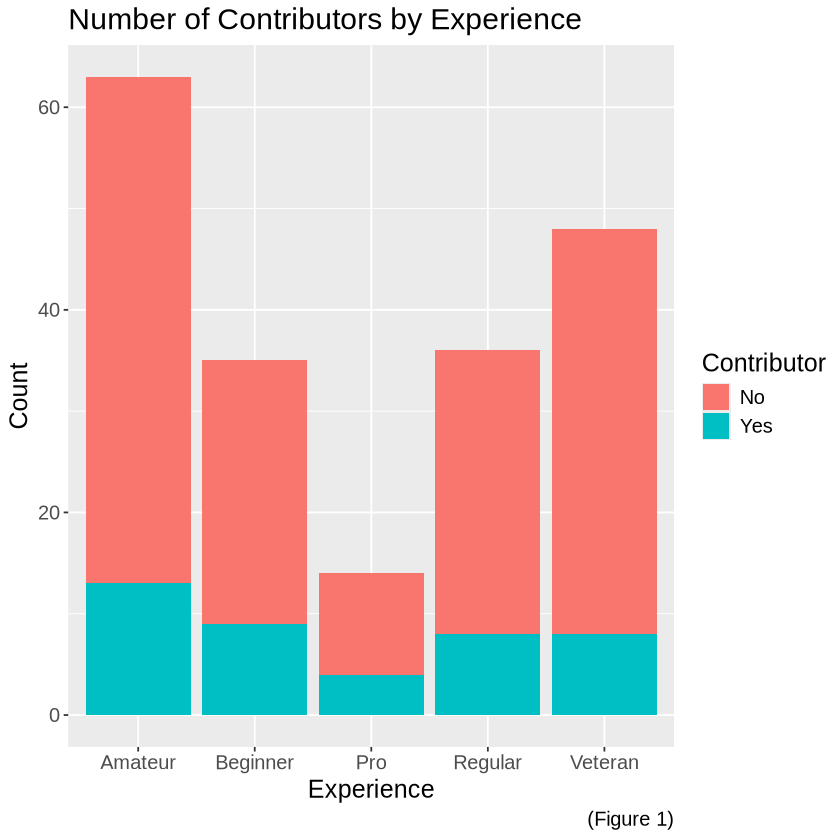

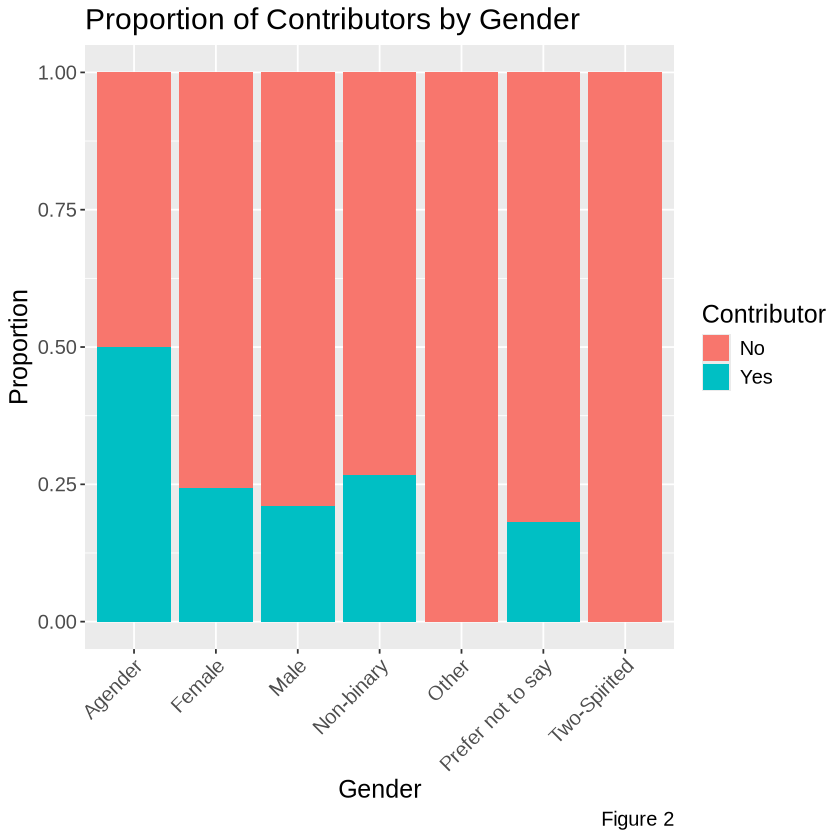

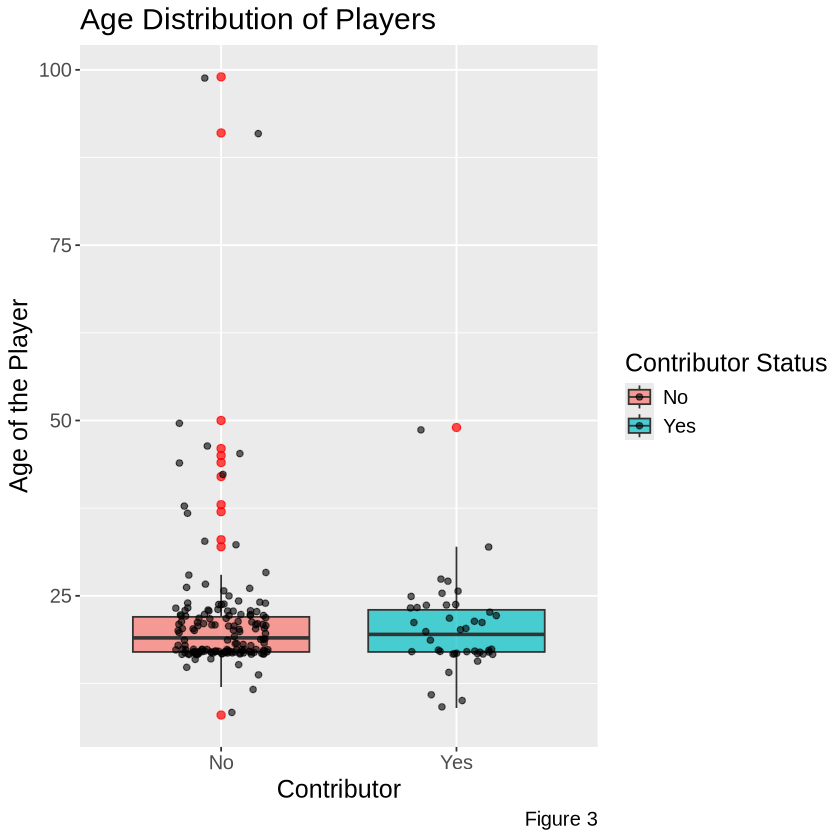

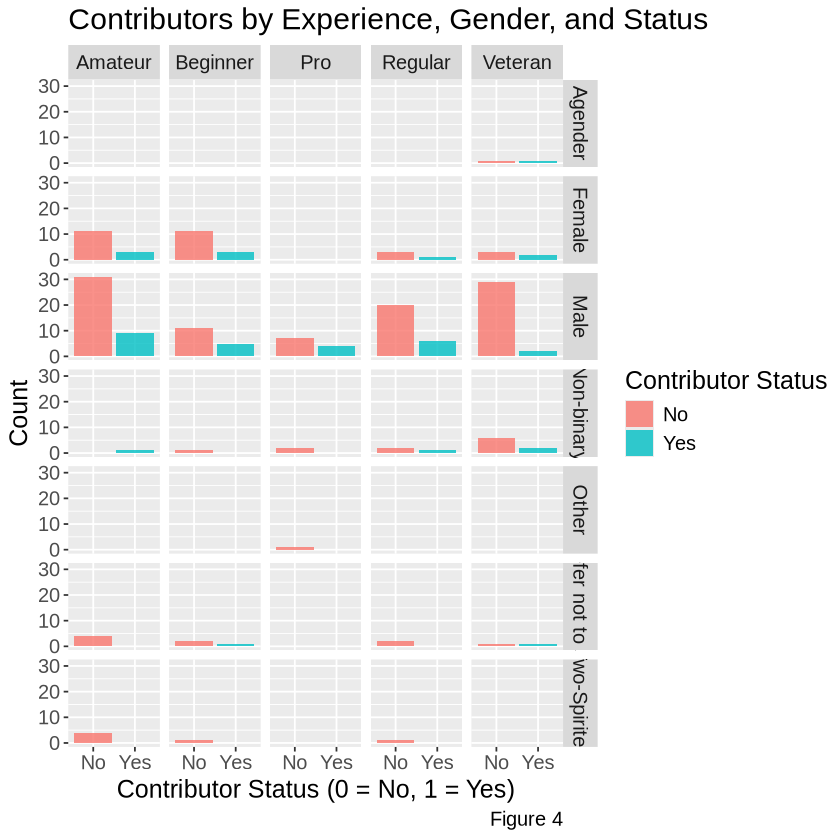

In [36]:
# Visualizing data

ggplot(test_data, aes(x = experience, fill = factor(contributor))) +
    geom_bar(position = "stack") +
    labs(
        title = "Number of Contributors by Experience",
        x = "Experience",
        y = "Count",
        fill = "Contributor",
        caption = "(Figure 1)"
    ) + 
    theme(text = element_text(size = 15))

ggplot(test_data, aes(x = gender, fill = factor(contributor))) +
    geom_bar(position = "fill") +
    labs(
        title = "Proportion of Contributors by Gender",
        x = "Gender",
        y = "Proportion",
        fill = "Contributor",
        caption = ("Figure 2")
    ) + 
    theme(text = element_text(size = 15),
         axis.text.x = element_text(angle = 45, hjust = 1))


ggplot(test_data, aes(x = factor(contributor), y = age, fill = factor(contributor))) +
    geom_boxplot(alpha = 0.7, outlier.size = 2, outlier.color = "red") +
    geom_jitter(width = 0.2, size = 1.5, alpha = 0.6, color = "black") +
    labs(
        title = "Age Distribution of Players",
        x = "Contributor",
        y = "Age of the Player",
        fill = "Contributor Status",
        caption = ("Figure 3")
    ) + 
    theme(text = element_text(size = 15))

ggplot(test_data, aes(x = factor(contributor), fill = factor(contributor))) +
    geom_bar(position = "stack", alpha = 0.8) +
    facet_grid(gender ~ experience) +
    labs(
        title = "Contributors by Experience, Gender, and Status",
        x = "Contributor Status (0 = No, 1 = Yes)",
        y = "Count",
        fill = "Contributor Status",
        caption = ("Figure 4")
    ) + 
    theme(text = element_text(size = 15))


### Data analysis
We use the method binary classification by knn

In [37]:
# Setting seed for reproducibility
set.seed(123)

# Splitting Data
players_split <- initial_split(test_data, prop = 0.75, strata = contributor)
players_train <- training(players_split)
players_test <- testing(players_split)

# Creating recipe
players_recipe <- recipe(contributor ~ experience + gender + age, data = players_train) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors()) |>
    step_dummy(all_nominal_predictors())

# Defining KNN specification
players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [38]:
# Cross-validation folds
players_folds <- vfold_cv(players_train, v = 5, strata = contributor)
players_k_values <- tibble(neighbors = seq(1, 20, by = 2))

# Tuning the model
players_knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_knn_spec) |>
    tune_grid(resamples = players_folds, grid = players_k_values) |>
    collect_metrics()

# Extracting best k from results
accuracies <- players_knn_results |> 
    filter(.metric == "accuracy")

best_k <- accuracies |> 
    arrange(desc(mean)) |> 
    slice(1) |> 
    pull(neighbors)

In [9]:
# Define KNN specification with best k
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Creating workflow with final specification
final_knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(final_knn_spec) |>
    fit(players_train)

# Making predictions on the testing data
test_predictions <- predict(final_knn_fit, new_data = players_test) |>
    bind_cols(players_test)
test_predictions

.pred_class,experience,gender,age,contributor
<fct>,<fct>,<fct>,<int>,<fct>
No,Veteran,Male,17,No
No,Amateur,Female,21,No
No,Regular,Male,21,No
⋮,⋮,⋮,⋮,⋮
No,Veteran,Male,17,No
No,Pro,Male,21,No
No,Amateur,Female,22,No


In [10]:
# Evaluate test metrics
test_results <- test_predictions |>
    mutate(correctness = if_else(contributor == .pred_class, "Correct", "Incorrect"))
cat("Final test result: \n")
test_results

cat("\n")

test_accuracy <- test_results |>
  summarise(accuracy = mean(correctness == "Correct")) |>
  pull(accuracy)

cat("The accuracy of the test result is:", test_accuracy, "\n")
cat("Best k:", best_k, "\n")

# Calculate accuracy
accuracy_result <- test_predictions |>
  metrics(truth = contributor, estimate = .pred_class) |>
  filter(.metric == "accuracy")
cat("\nAccuracy:\n")
print(accuracy_result)

cat("\n")

# Calculate precision
precision_result <- test_predictions |>
  precision(truth = contributor, estimate = .pred_class)
cat("\nPrecision:\n")
print(precision_result)

cat("\n")

# Calculating recall
recall_result <- test_predictions |>
  recall(truth = contributor, estimate = .pred_class)
cat("\nRecall:\n")
print(recall_result)

cat("\n")

# Confusion matrix
confusion_matrix <- test_predictions |>
  conf_mat(truth = contributor, estimate = .pred_class)
cat("\nConfusion Matrix:\n")
print(confusion_matrix)

Final test result: 


.pred_class,experience,gender,age,contributor,correctness
<fct>,<fct>,<fct>,<int>,<fct>,<chr>
No,Veteran,Male,17,No,Correct
No,Amateur,Female,21,No,Correct
No,Regular,Male,21,No,Correct
⋮,⋮,⋮,⋮,⋮,⋮
No,Veteran,Male,17,No,Correct
No,Pro,Male,21,No,Correct
No,Amateur,Female,22,No,Correct



The accuracy of the test result is: 0.76 
Best k: 11 

Accuracy:
# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary          0.76


Precision:
# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.776


Recall:
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary         0.974


Confusion Matrix:
          Truth
Prediction No Yes
       No  38  11
       Yes  1   0


## **Discussion:**

## **References:**

- https://www.geeksforgeeks.org/box-plot-in-r-using-ggplot2/
- https://www.geeksforgeeks.org/how-to-plot-3d-scatter-diagram-using-ggplot-in-r/
- https://recipes.tidymodels.org/articles/Simple_Example.html